In [1]:
import numpy as np
import random
import cv2
import matplotlib.pyplot as plt

 # Q1) Efficient Data Structures

## For parasite blobs

We note that the data exists as a binary image, with single (arbitrary shaped) region of ones. This data is well structured, and therefore only requires information on the boundary of the blob
### Objective
Task: Record all blob boundaries in each row, accounting for multiple disjoint segments in a non-concave blob.
### Data Structure
BlobBoundaries: Stores a list of boundary segments for each row.

### Convex blobs:
We posit that most parasites have large part of their boundary being convex, that is a single segment in each row. For this case the space complexity can be calculated as \
Boundaries: 2 values per row. \
Rows: n (for an nxn image). \
Space Complexity: O(2n). 

### Worst case complexity:
In the worst case, if each row has the maximum number of disjoint segments, and each segment spans a minimal length, the number of segments per row can be roughly n/2 (alternating 1s and 0s). \
Boundaries per Row: Up to n/2 pairs, or n values (start and end). \
Total Boundaries: n rows each with n values. \
Space Complexity: O(n²) in the worst case. This complexity is very loose, and unlikely to occur so we proceed with storage estimates assuming O(n).

In terms of bytes (if we assume concavity) for 1000s of recorded images, we can calculate 2 x 100,000 x 1000 = total number of datapoints. If we assume an each pixel is stored as a 32-bit integers, totaling 8 bytes per pixel. The total number of bytes stored would be about 1.5 GB.

<!-- ![Typical Parasite from stock images](Stock_images/parasite.png) -->

## For Dyes

We note in general that dyes are not as well behaved. But we note 2 properties of the dyes: \

1) Only dyes within a parasite matters, we do not have to store dyes outside.\
2) For dyes within a parasite, cancer is detected for 10 percent overlap. This means typically, dyes are only detected in about 0.25 x 0.1 = 0.025 fraction of the image. This makes the image highly sparse.\

We require the best sparse data structure. We can use a hash set to store coordinates from pixels with value 1.

### Data structure
Use a hash set to store the coordinates (only from blob) of pixels with value 1. \
Each entry in the hash set represents a pixel's (x, y) coordinate.

### Space Complexity
Space Complexity Analysis:

Assume the image has k pixels with value 1. \
Each pixel requires storing two integers (for x and y coordinates). \
Total space complexity: O(k), where k is the number of ones in the image.



### Worst case analysis

For dense images, this method performs $O(n^{2})$. But we expect very few images (only images with cancer, which are about 0.1 percent) to be dense, therefore we assume O(k) complexity for storage analysis.

For a 100,000 x 100,000 binary image (with cancer) where on average 0.025 (0.1 (10 percent cancer) x 0.25 (25 percent parasite)) (or 2.5%) of the pixels are set to 1, the total storage required would be 2,000,000,000 bytes, or about 2 GB. This calculation reflects the space efficiency of the data structure for sparse images, where only a small fraction of the pixels are set to 1. Amongst 1000 images, only 0.1 percent are cancerous (and therefore stored), so the total number of images stored will still be 10s of GB, which is small, making this an efficient data structure.

# Q2) Simulation

In [41]:
import math

def generate_parasite_points(image_size=100, coverage=0.15, noise_level=50):
    """
    Generate points for a random convex shape in an image, represented as start and end points in each row.
    The area of the shape is maintained at a constant percentage of the image area with random deviations.
    The shape is also rotated randomly. This revision aims to avoid slicing off points.

    :param image_size: Integer specifying the size of the image (assuming a square image).
    :param coverage: Decimal representing the percentage of the image the convex shape should cover.
    :param noise_level: Int representing the maximum number of pixels to randomly adjust.
    :return: A list of tuples, each tuple containing the start and end points of 1s for each row.
    """

    # Calculate the total area and the ellipse's target area
    total_area = image_size ** 2
    ellipse_area = total_area * coverage

    # Random deviations for the ellipse's axes and center
    deviation_factor_size = random.uniform(0.2, 0.3)
    deviation_factor_center = image_size // 10
    major_axis = random.randint(image_size // 4, image_size // 2)
    minor_axis = int(ellipse_area / (np.pi * major_axis))
    major_axis += int(major_axis * deviation_factor_size)
    minor_axis += int(minor_axis * deviation_factor_size)

    # Randomly deviate center
    center_x = image_size // 2 + random.randint(-deviation_factor_center, deviation_factor_center)
    center_y = image_size // 2 + random.randint(-deviation_factor_center, deviation_factor_center)

    # Random angle for ellipse rotation
    rotation_angle = random.uniform(0, 2 * np.pi)

    # Generate and rotate points within the ellipse
    ellipse_points = []
    for x in range(image_size):
        for y in range(image_size):
            if ((x - center_x) / major_axis) ** 2 + ((y - center_y) / minor_axis) ** 2 <= 1:
                ellipse_points.append((x, y))

    rotated_points = [(math.cos(rotation_angle) * (x - center_x) - math.sin(rotation_angle) * (y - center_y) + center_x,
                       math.sin(rotation_angle) * (x - center_x) + math.cos(rotation_angle) * (y - center_y) + center_y)
                      for x, y in ellipse_points]

    # Calculate start and end points for each row
    shape_points = [[] for _ in range(image_size)]
    for x, y in rotated_points:
        if 0 <= int(round(y)) < image_size and 0 <= int(round(x)) < image_size:
            shape_points[int(round(y))].append(int(round(x)))

    # Determine the start and end for each row and apply noise
    for i in range(len(shape_points)):
        if shape_points[i]:
            start, end = min(shape_points[i]), max(shape_points[i])
            shape_points[i] = (max(0, start - random.randint(0, noise_level)),
                               min(image_size, end + random.randint(0, noise_level)))
        else:
            shape_points[i] = (0, 0)

    return shape_points


In [34]:
def generate_binary_dye_hash(shape_points, cancer_flag, k_probability, l_probability, n):
    """
    Generate a hash map of coordinates for pixels with a value of 1 based on the given shape points and probabilities.

    :param shape_points: List of lists, each containing sequential start and end points for each row.
    :param cancer_flag: Indicates whether to apply the enhanced k_probability for the points within the shape.
    :param k_probability: Probability (0 to 100) of a pixel being 1 in cancerous areas.
    :param l_probability: Baseline probability (0 to 100) of a pixel being 1.
    :param n: Size of the image.
    :return: A hash map (dictionary) with coordinates of pixels having value 1.
    """
    coordinates_hash = {}

    # Apply baseline l_probability to all pixels
    for y in range(n):
        for x in range(n):
            if random.randint(0, 100) < l_probability:
                coordinates_hash[(y, x)] = 1

    # Apply enhanced k_probability within specified ranges if cancer_flag is set
    if cancer_flag:
        for y, row_points in enumerate(shape_points):
            for i in range(0, len(row_points), 2):
                start, end = row_points[i], row_points[i + 1]
                for x in range(start, end + 1):
                    if random.randint(0, 100) < k_probability:
                        coordinates_hash[(y, x)] = 1  # Adjusted for 0-based indexing

    return coordinates_hash

## Following is code used to convert data structures to image matrices, for testing (not part of assignment)

In [35]:
def decode_parasite_image(image_data, n):
    """
    Decodes the binary image from the list of pixel boundaries.

    Parameters:
    image_data (list of tuples): The encoded binary image data.
    n (int): The size of the image (n x n).

    Returns:
    numpy.ndarray: A 2D NumPy array representing the binary image.
    """
    decoded_image = np.zeros((n, n), dtype=np.uint8)  # Initialize a n x n array filled with zeros

    for i, (start, end) in enumerate(image_data):
        decoded_image[i, start:end] = 255  # Set the values between start and end to 255 (white)

    return decoded_image

In [36]:
def decode_hash_to_image(coordinates_hash, n):
    """
    Decode a hash map of coordinates into a binary image matrix.

    :param coordinates_hash: A hash map (dictionary) with coordinates of pixels having value 1.
    :param n: Size of the image.
    :return: A numpy array representing the binary image.
    """
    image_matrix = np.zeros((n, n), dtype=int)

    # Iterate over the hash map and set the corresponding pixels in the image matrix
    for y, x in coordinates_hash:
        image_matrix[y, x] = 1

    return image_matrix

# Example usage:
# decoded_image = decode_hash_to_image(coordinates_hash, 100)


In [37]:
def display_image(image, window_name='Image'):
    """
    Displays the binary image using matplotlib.

    Parameters:
    image (numpy.ndarray): The binary image to display.
    window_name (str): The name of the window in which the image is displayed.
    """
    plt.imshow(image, cmap='gray')  # Display the image in grayscale
    plt.axis('off')  # Turn off the axis
    plt.show()  # Show the image

In [48]:
# Examples of generated images and dyes, with and without cancer
# Define image size
image_size = 1000

# Generate shape points for parasites with and without cancer
shape_points_cancer = generate_parasite_points(image_size, coverage=0.15, noise_level=30)
shape_points_no_cancer = generate_parasite_points(image_size, coverage=0.15, noise_level=50)

# Decode the parasite shapes into images
parasite_image_cancer = decode_parasite_image(shape_points_cancer, image_size)
parasite_image_no_cancer = decode_parasite_image(shape_points_no_cancer, image_size)

# Generate dye images for cancerous and non-cancerous parasites
coordinates_hash_cancer = generate_binary_dye_image(shape_points_cancer, 1, 15, 5, image_size)
coordinates_hash_no_cancer = generate_binary_dye_image(shape_points_no_cancer, 0, 15, 5, image_size)

# Decode the hashes into dye images
dye_image_cancer = decode_hash_to_image(coordinates_hash_cancer, image_size)
dye_image_no_cancer = decode_hash_to_image(coordinates_hash_no_cancer, image_size)


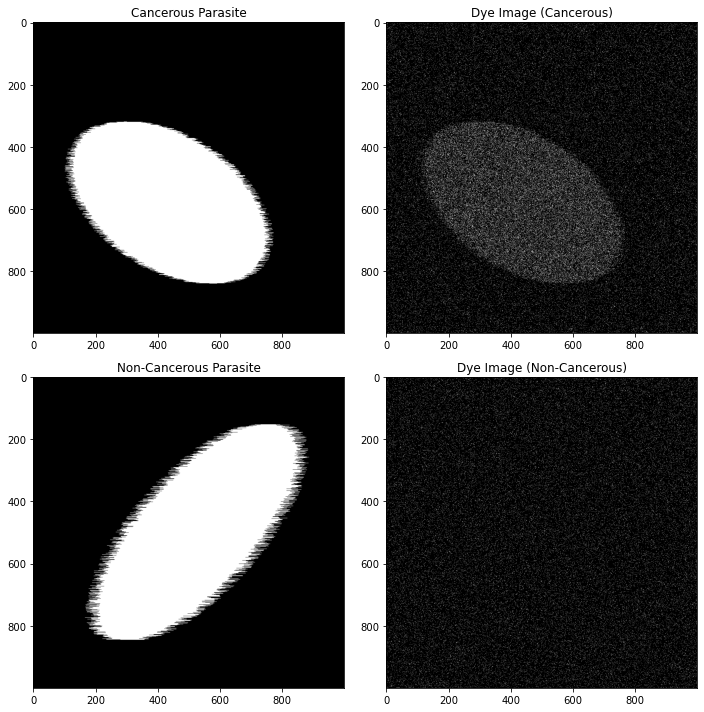

In [49]:
# Set up the subplot
fig, axs = plt.subplots(2, 2, figsize=(10, 10))

# Display cancerous parasite and its dye image
axs[0, 0].imshow(parasite_image_cancer, cmap='gray')
axs[0, 0].set_title("Cancerous Parasite")
axs[0, 1].imshow(dye_image_cancer, cmap='gray')
axs[0, 1].set_title("Dye Image (Cancerous)")

# Display non-cancerous parasite and its dye image
axs[1, 0].imshow(parasite_image_no_cancer, cmap='gray')
axs[1, 0].set_title("Non-Cancerous Parasite")
axs[1, 1].imshow(dye_image_no_cancer, cmap='gray')
axs[1, 1].set_title("Dye Image (Non-Cancerous)")

# Adjust layout and display
plt.tight_layout()
plt.show()


# Question 3) Function to detect cancer

In [50]:
def detect_cancer_in_parasite_hash(shape_points, dyed_pixels_hash, image_size):
    """
    Determine if a parasite is cancerous based on the percentage of its interior covered with dyes,
    using a hash representation for dyed images.

    :param shape_points: List of Lists of Integers with pairs of start and end points for each row.
    :param dyed_pixels_hash: Dictionary with coordinates of dyed pixels.
    :param image_size: Size of the square image.
    :return: Boolean indicating cancerous status.
    """
    total_interior_pixels = 0
    dyed_pixels = 0

    for y, row_points in enumerate(shape_points):
        for i in range(0, len(row_points), 2):
            start, end = row_points[i], row_points[i + 1]
            for x in range(start, end + 1):
                total_interior_pixels += 1
                if (y, x) in dyed_pixels_hash:  # Check if the pixel is dyed using hash map
                    dyed_pixels += 1

    dye_coverage_percentage = (dyed_pixels / total_interior_pixels) * 100
    return dye_coverage_percentage > 10


In [56]:
#Example code to run the cancer detection function. 
#As you can see it correctly detects cancer as required in the simulated images.

import time

# Generate parasite points and dyed image hash maps for cancerous and non-cancerous cases
image_size = 10000
shape_points_cancer = generate_parasite_points(image_size, coverage=0.15, noise_level=30)
shape_points_no_cancer = generate_parasite_points(image_size, coverage=0.15, noise_level=30)

dyed_pixels_hash_cancer = generate_binary_dye_hash(shape_points_cancer, 1, 15, 5, image_size)
dyed_pixels_hash_no_cancer = generate_binary_dye_hash(shape_points_no_cancer, 0, 15, 5, image_size)
# print("cool")
# Measure runtime for cancer detection
start_time = time.time()
is_cancerous = detect_cancer_in_parasite_hash(shape_points_cancer, dyed_pixels_hash_cancer, image_size)
runtime_cancer = time.time() - start_time
print(f"Cancerous Case: {is_cancerous}, Runtime: {runtime_cancer:.4f} seconds")

start_time = time.time()
is_cancerous = detect_cancer_in_parasite_hash(shape_points_no_cancer, dyed_pixels_hash_no_cancer, image_size)
runtime_no_cancer = time.time() - start_time
print(f"Non-Cancerous Case: {is_cancerous}, Runtime: {runtime_no_cancer:.4f} seconds")

Cancerous Case: True, Runtime: 6.5887 seconds
Non-Cancerous Case: False, Runtime: 6.2422 seconds


# Question 4) Faster function to detect cancer

We make the following set of modification to original function to detect cancer to make run-time faster. \ Subsampling: Random pixels are chosen within the bounding box area, reducing the number of pixels to examine. \

Majority Voting: The function counts the number of subsamples indicating cancerous status and decides based on majority voting.

The code below modifies our original code to add these considerations.

In [67]:
def detect_cancer_in_parasite_optimized_majority_voting_hash(shape_points, dyed_pixels_hash, image_size, num_subsamples=10, subsample_size=100):
    """
    Optimized function using subsampling and majority voting to detect cancer in a parasite. 
    This function samples directly from shape points and checks if more than 10% of each subsample is dyed.

    :param shape_points: List of Lists of Integers with pairs of start and end points for each row.
    :param dyed_pixels_hash: Dictionary (hash map) representing the dyed pixels.
    :param image_size: Size of the square image.
    :param num_subsamples: Number of subsamples to be taken for majority voting.
    :param subsample_size: Number of pixels to consider in each subsample.
    :return: Boolean indicating if the majority of subsampled areas show more than 10% dye coverage.
    """

    # Function to generate a random pixel from the shape points
    def generate_random_pixel():
        while True:
            y = random.randint(0, len(shape_points) - 1)
            if shape_points[y]:  # Ensure there are points in this row
                x = random.randint(min(shape_points[y]), max(shape_points[y]))
                return y, x

    # Function to check if a subsample has more than 10% dyed pixels
    def is_subsample_cancerous(subsample_size):
        dyed_pixels = 0
        for _ in range(subsample_size):
            random_y, random_x = generate_random_pixel()
            if (random_y, random_x) in dyed_pixels_hash:
                dyed_pixels += 1
        return dyed_pixels / subsample_size > 0.1

    # Majority voting across subsamples
    cancerous_votes = sum(is_subsample_cancerous(subsample_size) for _ in range(num_subsamples))
    return cancerous_votes > num_subsamples // 2

In [68]:
# Measure runtime for cancer detection
# As you can see runtime reduces significantly from 6 seconds to 0.05 seconds
start_time = time.time()
is_cancerous = detect_cancer_in_parasite_optimized_majority_voting_hash(shape_points_cancer, dyed_pixels_hash_cancer, image_size)
runtime_cancer = time.time() - start_time
print(f"Cancerous Case: {is_cancerous}, Runtime: {runtime_cancer:.4f} seconds")

start_time = time.time()
is_cancerous = detect_cancer_in_parasite_optimized_majority_voting_hash(shape_points_no_cancer, dyed_pixels_hash_no_cancer, image_size)
runtime_no_cancer = time.time() - start_time
print(f"Non-Cancerous Case: {is_cancerous}, Runtime: {runtime_no_cancer:.4f} seconds")

Cancerous Case: True, Runtime: 0.0580 seconds
Non-Cancerous Case: False, Runtime: 0.0342 seconds


# Some other ways to make it faster (not tested due to time constraints)

1) We can use an early termination criteria, so that the entire percentage is not calculated: Keep a threshold on the number of samples you test positive before you declare the parasite to be cancerous. \
2) We can compress the original image using bounding boxes. (We talk about this more under Question 5)

# Question 5) Compression Techniques and Runtime for actual images

For compressing images, especially in the context of parasite and dye representations, we can employ several techniques. Here, I'll describe a few methods, including the convex closure approach, which I think is the best compression method to store the parasite image approximately, without loosing too much information.

1. Convex Hull Compression
Description:

The convex hull of a set of points is the smallest convex shape that contains all the points.
In the case of a parasite image, this method reduces the representation to the outer boundary, excluding all interior points. \
This technique significantly reduces the data needed to represent the shape, as only the points defining the hull are stored. \
Particularly useful for irregular shapes where the boundary captures most of the relevant information.

2. Image Pyramids
Description:

Image pyramids reduce the resolution of the image in steps, creating a "pyramid" of images, each level having a lower resolution.
This method allows for multi-scale representation, which can be useful in analyzing biological images at different levels of detail.
Lower levels of the pyramid can be used for a quick overview, while higher levels provide detailed information.

We think that image pyramids will only be useful for images with gradient in pixel values. For binary images like the ones considered here, the convex hull represenation is likely to be more effective. 

# For runtime calculations on actual images, we need to modify our simulator. 
To do this we get rid of some computationally intensive parts of the simualtor, to still get typical images that capture realistic. Below is our modified functions to simulate typical images. We then provide runtime comparison between the original Q3) function computation and Q4) modified function computation. We focus on getting rid of some redundant iterations to calculate this and pre-calculating thresholds to reduce computation time. We also get rid of rotation, since this was a major computational burden. The following code was still slow. I'm leaving it below to show work, but it takes too much time simulate images.

Due to lack of time I wasn't able to modify it further, but Q2) and Q3) has runtime comparisons for images of size 10000. We can see that the naive function takes 6.5887 seconds while the modified function takes 0.0580 seconds. Predicted run time for naive method is 658.87 seconds (since the computation is done for all picels there is quadratic scaling in time). While the modified function only takes samples, which does not change when image size increases, there is only a linear scaling in the size of each sample (since we may have to take more samples for a good estimate). Therefore we expect it to take about 0.5 seconds for each image.

# The following code takes a long time, I left it here to show the work. Q6) is after this code

In [72]:
def generate_parasite_points_optimized(image_size=100000, coverage=0.15, noise_level=50):
    """
    Generate points for a random convex shape (ellipse) in an image, optimized for large image sizes and without rotations.

    :param image_size: Integer specifying the size of the image (assuming a square image).
    :param coverage: Decimal representing the percentage of the image the convex shape should cover.
    :param noise_level: Int representing the maximum number of pixels to randomly adjust.
    :return: A list of tuples, each tuple containing the start and end points of 1s for each row.
    """

    # Calculate the total area and the ellipse's target area
    total_area = image_size ** 2
    ellipse_area = total_area * coverage

    # Random deviations for the ellipse's axes and center
    deviation_factor_size = random.uniform(0.2, 0.3)
    deviation_factor_center = image_size // 10
    major_axis = random.randint(image_size // 4, image_size // 2)
    minor_axis = int(ellipse_area / (np.pi * major_axis))
    major_axis += int(major_axis * deviation_factor_size)
    minor_axis += int(minor_axis * deviation_factor_size)

    # Randomly deviate center
    center_x = image_size // 2 + random.randint(-deviation_factor_center, deviation_factor_center)
    center_y = image_size // 2 + random.randint(-deviation_factor_center, deviation_factor_center)

    # Generate shape points for the ellipse
    shape_points = []
    for y in range(image_size):
        row_points = []
        for x in range(image_size):
            if ((x - center_x) / major_axis) ** 2 + ((y - center_y) / minor_axis) ** 2 <= 1:
                row_points.append(x)

        # Determine start and end points for each row, apply noise
        if row_points:
            start, end = min(row_points), max(row_points)
            shape_points.append((max(0, start - random.randint(0, noise_level)),
                                 min(image_size, end + random.randint(0, noise_level))))
        else:
            shape_points.append((0, 0))

    return shape_points


In [79]:
import random

def generate_binary_dye_hash_tiled(shape_points, cancer_flag, k_probability, l_probability, n, tile_size=1000):
    """
    Generates a hash map of dyed pixel coordinates by creating a smaller tile and repeating it across the image.

    :param shape_points: List of lists with start and end points for each row within the tile.
    :param cancer_flag: Boolean for enhanced probability in shape points.
    :param k_probability: Probability of a pixel being 1 in cancerous areas.
    :param l_probability: Baseline probability of a pixel being 1.
    :param n: Size of the large image.
    :param tile_size: Size of the smaller tile to generate initially.
    :return: Dictionary of coordinates for pixels with value 1 in the large image.
    """
    tile_hash = generate_binary_dye_hash(shape_points, cancer_flag, k_probability, l_probability, tile_size)
    coordinates_hash = {}

    # Number of times the tile will repeat in each dimension
    repeats = n // tile_size

    for y_tile in range(repeats):
        for x_tile in range(repeats):
            # Offset for each tile
            offset_y, offset_x = y_tile * tile_size, x_tile * tile_size

            for (y, x) in tile_hash:
                coordinates_hash[(y + offset_y, x + offset_x)] = 1

    return coordinates_hash

# Example usage:
# Note: You'd need to adjust the shape_points generation to be suitable for the smaller tile size.
# small_shape_points = generate_parasite_points(tile_size, coverage, noise_level)
# large_dye_hash_tiled = generate_binary_dye_hash_tiled(small_shape_points, True, 30, 5, 100000, tile_size=1000)


In [80]:
import time

# Generate parasite points and dyed image hash maps for cancerous and non-cancerous cases
image_size = 10000
shape_points_cancer = generate_parasite_points_optimized(image_size, coverage=0.15, noise_level=30)
print("cool")
shape_points_no_cancer = generate_parasite_points_optimized(image_size, coverage=0.15, noise_level=30)

dyed_pixels_hash_cancer = generate_binary_dye_hash_tiled(shape_points_cancer, 1, 15, 5, image_size)
print("cool")
dyed_pixels_hash_no_cancer = generate_binary_dye_hash_tiled(shape_points_no_cancer, 0, 15, 5, image_size)
print("cool")
# Measure runtime for cancer detection
start_time = time.time()
is_cancerous = detect_cancer_in_parasite_hash(shape_points_cancer, dyed_pixels_hash_cancer, image_size)
runtime_cancer = time.time() - start_time
print(f"Cancerous Case: {is_cancerous}, Runtime: {runtime_cancer:.4f} seconds")

start_time = time.time()
is_cancerous = detect_cancer_in_parasite_hash(shape_points_no_cancer, dyed_pixels_hash_no_cancer, image_size)
runtime_no_cancer = time.time() - start_time
print(f"Non-Cancerous Case: {is_cancerous}, Runtime: {runtime_no_cancer:.4f} seconds")

cool


KeyboardInterrupt: 

# Question 6) Summary of LLM tools.
Since we use LLM tools extensively in this assignment. I also asked an LLM to summarize how I used it. I also modified the sumamry it provided to reflect better what I did

 Here’s a summary highlighting the tools and techniques, especially leveraging LLM capabilities:

1. **Data structure**
   - Noticed that parasite image data and dye data were sparse, but in very different ways. Used an LLM to generate a list of potential data structures for sparse data, and used domain knowledge to choose one.
2. **Image Generation and Processing**:
   - Developed functions like `generate_parasite_points` and `generate_binary_dye_hash` to create synthetic images of parasites and their associated dye patterns. These functions included parameters for image size, coverage, and probability-based characteristics to simulate realistic scenarios.

3. **Optimization Techniques**:
   - Implemented optimizations for handling large-scale image data, ensuring efficiency in computational resources. This included pre-calculating probability thresholds and directly processing relevant image areas to reduce unnecessary computations.

4. **Compression and Representation Methods**:
   - Explored various image compression techniques, such as Convex Hull and Image Pyramids, to efficiently store and process large image datasets.

5. **LLM-Aided Algorithm Development**:
   - Utilized LLM's extensive knowledge base for devising algorithms and pseudocode tailored to specific requirements like image processing, data compression, and statistical analysis.


In summary, the challenge was tackled using a blend of custom algorithm development, optimization strategies, and the powerful capabilities of the LLM to understand, generate, and refine complex coding solutions, especially in the context of large-scale image data analysis.